# Ejercicio 1

Inicializamos el conjunto de datos de partida, junto con el vector de valores de $\alpha$ y el valor de C.

In [1]:
import numpy as np

dataset = np.array([[2,6,1],[4,3,1],[4,4,1],[4,6,1],[6,3,1],[7,7,1],[8,4,1], [9,8,1],[2,1,-1],[6,2,-1],[7,4,-1],
                    [8,8,-1],[9,1,-1],[10,3,-1],[10,6,-1],[12,4,-1]])
X = dataset[:,0:dataset.shape[1]-1]
Y = dataset[:,dataset.shape[1]-1]
alphas = np.array([0,1,0.3333,0,1,0.1667,1,1,1,0.5,1,1,0,0,1,0])
C=1

### Apartado a

Los vectores de soporte son aquellos que tienen un valor de $\alpha > 0$, mientras que los vectores que están sobre el borde son los que tienen un valor de $\alpha \in (0,\text C)$.

In [2]:
support_vectors = [idx for idx,alpha in enumerate(alphas) if alpha > 0]
edge_vectors = [idx for idx,alpha in enumerate(alphas) if alpha > 0 and alpha < C]

In [3]:
print support_vectors
print edge_vectors

[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14]
[2, 5, 9]


### Apartado b

Obtenemos los valores de $\beta$ aplicando la fórmula de los apuntes: $\beta = \sum_{i=1}^{16} \alpha_iy_ix_i$.

In [2]:
(alphas*Y)[:,None]

array([[ 0.    ],
       [ 1.    ],
       [ 0.3333],
       [ 0.    ],
       [ 1.    ],
       [ 0.1667],
       [ 1.    ],
       [ 1.    ],
       [-1.    ],
       [-0.5   ],
       [-1.    ],
       [-1.    ],
       [-0.    ],
       [-0.    ],
       [-1.    ],
       [-0.    ]])

In [3]:
X

array([[ 2,  6],
       [ 4,  3],
       [ 4,  4],
       [ 4,  6],
       [ 6,  3],
       [ 7,  7],
       [ 8,  4],
       [ 9,  8],
       [ 2,  1],
       [ 6,  2],
       [ 7,  4],
       [ 8,  8],
       [ 9,  1],
       [10,  3],
       [10,  6],
       [12,  4]])

In [4]:
beta = sum((alphas*Y)[:,None]*X)
beta

array([-0.4999,  0.5001])

Para obtener $\beta_0$, hemos de tomar un elemento $x_i$ que cumpla que $0<\alpha_i<C$, y calcular $\beta_0$ despejando de:

$$\alpha_i[y_i(x_i^T\beta + \beta_0) -1] = 0$$

En este caso hemos tomado el primer vector que está en el borde (la observación 2).

In [5]:
idx = edge_vectors[0]
beta0 = (1/Y[idx]) - np.matmul(X[idx],beta)
beta0

0.9992000000000019

El valor de $M$ se obtiene como $1/||\beta||$.

In [6]:
M = 1/np.linalg.norm(beta)
M

1.4142135340888247

### Apartado c

Por las ecuaciones (2) y (5) de la diapositiva 14 de los apuntes, sabemos que cuando $\alpha_i = 0$, entonces $\epsilon_i = 0$. De hecho, cuando $0<\alpha_i< C$, también se tiene que $\epsilon_i=0$. Sin embargo, cuando $\alpha_i=C$, se tiene que $\mu_i=0$, lo que implica que $\epsilon_i$ no tiene por qué ser cero, y se calcula usando la fórmula (1).

In [7]:
eps = []
for idx,alpha in enumerate(alphas):
    if alpha < C:
        eps.append(0)
    else:
        eps.append(1-Y[idx]*(np.matmul(X[idx],beta)+beta0))
eps

[0,
 0.5000999999999998,
 0,
 0,
 1.4999000000000002,
 0,
 1.999600000000001,
 0.4991000000000021,
 1.4995000000000012,
 0,
 0.5002999999999993,
 2.000799999999998,
 0,
 0,
 0.0007999999999981355,
 0]

Las observaciones que están incorrectamente clasificadas son las que tienen un valor $\epsilon_i > 1$ (están en el lado incorrecto del hiperplano).

In [8]:
misclassified = [idx for idx,x in enumerate(eps) if x > 1]
misclassified

[4, 6, 8, 11]

# Ejercicio 2

Importamos las librerías necesarias para la realización de los ejercicios 2 y 3.

In [5]:
from sklearn import preprocessing, cross_validation, svm
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.externals import joblib
import sklearn.metrics as metrics

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from operator import itemgetter


Fijamos la semilla, cargamos el dataset y dividimos en train/test. Estandarizamos la entrada.

In [16]:
np.random.seed(1)
datasetName = '../datos/bloodTransfusion.data'
datasetDelimiter = ','

# load the CSV file as a numpy matrix
dataset = np.loadtxt(datasetName, delimiter=datasetDelimiter)
xRaw = dataset[:,0:dataset.shape[1]-1]
y = dataset[:,dataset.shape[1]-1]

#Divide in training and test, shuffling the examples and keeping the proportion of examples of each class
xTrain_tmp, xTest_tmp, yTrain, yTest = cross_validation.train_test_split(xRaw, y, test_size=0.2)

#Standardize data
scaler = preprocessing.StandardScaler().fit(xTrain_tmp)
xTrain=scaler.transform(xTrain_tmp)
xTest=scaler.transform(xTest_tmp)

Procedemos a realizar el entrenamiento para los valores de los hiperparámetros que se muestran a continuación, con el algoritmo `svm.SVC` de `scikit-learn`. Para el kernel lineal, solo se utiliza el hiperparámetro C. Para el kernel `rbf`, se utilizan C y $\gamma$. Y para el kernel polinómico, se utilizan C y degree.

In [11]:
#Generate grid search
kernels = ['linear', 'rbf', 'poly']
degrees = [2,3,4]
Cs = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,15,25,50]
gammas = [0.0001,0.001,0.01,0.05, 0.1, 0.5, 1, 2.5, 5, 10]

hyperParamsLinear = {'C': Cs}
hyperParamsRbf = {'C': Cs, 'gamma': gammas}
hyperParamsPoly = {'C': Cs, 'degree': degrees}

modelCVLinear = GridSearchCV(svm.SVC(kernel="linear"), hyperParamsLinear, cv=5, scoring='accuracy')
modelCVLinear.fit(xTrain, yTrain)

print "Best hyperparameter", modelCVLinear.best_params_
print "\n\n"

errListLinear, devListLinear = [], []
for hyperP, mean_score, scores in modelCVLinear.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std(), hyperP))
    errListLinear.append(1-mean_score)
    devListLinear.append(scores.std())

modelCVRbf = GridSearchCV(svm.SVC(kernel="rbf"), hyperParamsRbf, cv=5, scoring='accuracy')
modelCVRbf.fit(xTrain, yTrain)
    
print "\n\n"
print "Best hyperparameter", modelCVRbf.best_params_
print "\n\n"

erroresRbf = { "Gamma:"+str(gamma):[] for gamma in gammas}
devsRbf = { "Gamma:"+str(gamma):[] for gamma in gammas}
for hyperP, mean_score, scores in modelCVRbf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std(), hyperP))
    erroresRbf["Gamma:"+str(hyperP['gamma'])].append(1-mean_score)
    devsRbf["Gamma:"+str(hyperP['gamma'])].append(scores.std())

modelCVPoly = GridSearchCV(svm.SVC(kernel="poly", gamma=1), hyperParamsPoly, cv=5, scoring='accuracy')
modelCVPoly.fit(xTrain, yTrain)

print "\n\n"
print "Best hyperparameter", modelCVPoly.best_params_
print "\n\n"
    
erroresPoly = { "Degree:"+str(degree):[] for degree in degrees}
devsPoly = { "Degree:"+str(degree):[] for degree in degrees}
for hyperP, mean_score, scores in modelCVPoly.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std(), hyperP))
    erroresPoly["Degree:"+str(hyperP['degree'])].append(1-mean_score)
    devsPoly["Degree:"+str(hyperP['degree'])].append(scores.std())

Best hyperparameter {'C': 0.001}



0.771 (+/-0.003) for {'C': 0.001}
0.771 (+/-0.003) for {'C': 0.005}
0.771 (+/-0.003) for {'C': 0.01}
0.771 (+/-0.003) for {'C': 0.05}
0.771 (+/-0.003) for {'C': 0.1}
0.771 (+/-0.003) for {'C': 0.5}
0.769 (+/-0.003) for {'C': 1}
0.769 (+/-0.003) for {'C': 5}
0.769 (+/-0.003) for {'C': 10}
0.769 (+/-0.003) for {'C': 15}
0.769 (+/-0.003) for {'C': 25}
0.769 (+/-0.003) for {'C': 50}



Best hyperparameter {'C': 15, 'gamma': 0.5}



0.771 (+/-0.003) for {'C': 0.001, 'gamma': 0.0001}
0.771 (+/-0.003) for {'C': 0.001, 'gamma': 0.001}
0.771 (+/-0.003) for {'C': 0.001, 'gamma': 0.01}
0.771 (+/-0.003) for {'C': 0.001, 'gamma': 0.05}
0.771 (+/-0.003) for {'C': 0.001, 'gamma': 0.1}
0.771 (+/-0.003) for {'C': 0.001, 'gamma': 0.5}
0.771 (+/-0.003) for {'C': 0.001, 'gamma': 1}
0.771 (+/-0.003) for {'C': 0.001, 'gamma': 2.5}
0.771 (+/-0.003) for {'C': 0.001, 'gamma': 5}
0.771 (+/-0.003) for {'C': 0.001, 'gamma': 10}
0.771 (+/-0.003) for {'C': 0.005, 'gamma': 0.0001}

Gráfica con el error de validación cruzada frente al valor del hiperparámetro para el kernel lineal.

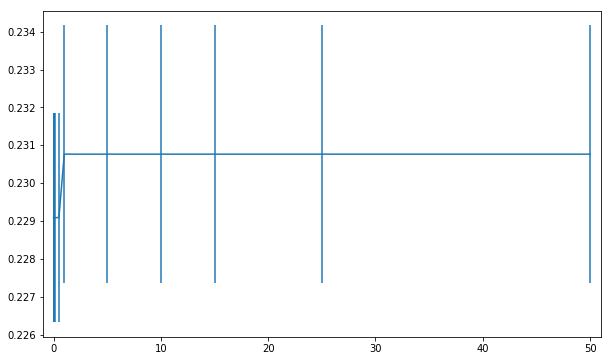

In [12]:
plt.figure(figsize=(10,6))
plt.errorbar(Cs, errListLinear, yerr=devListLinear)
plt.xlim(Cs[0]-1, Cs[len(Cs)-1]+1)
plt.show()

In [13]:
from itertools import izip

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return izip(a, a)

Gráficas con el error de validación cruzada frente al valor de C para el kernel `rbf`. Hemos decidido mostrarlas en grupos de dos, para lo que hemos definido, como en la práctica anterior, una función llamada `pairwise` que, dada una lista, nos devuelve la misma en pares de valores, lo que nos permite recorrerla de dos en dos.

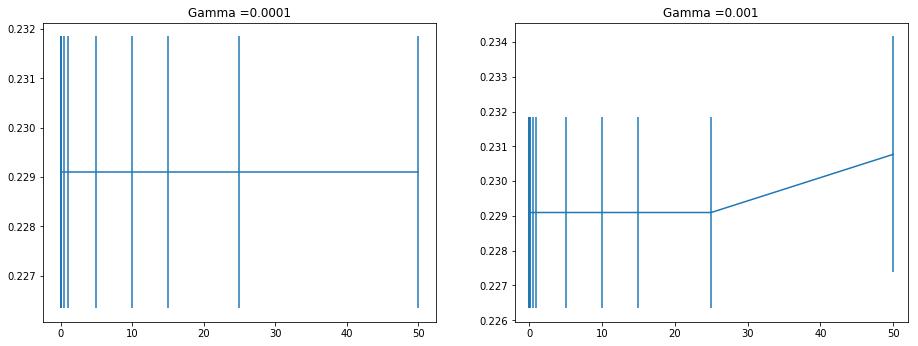

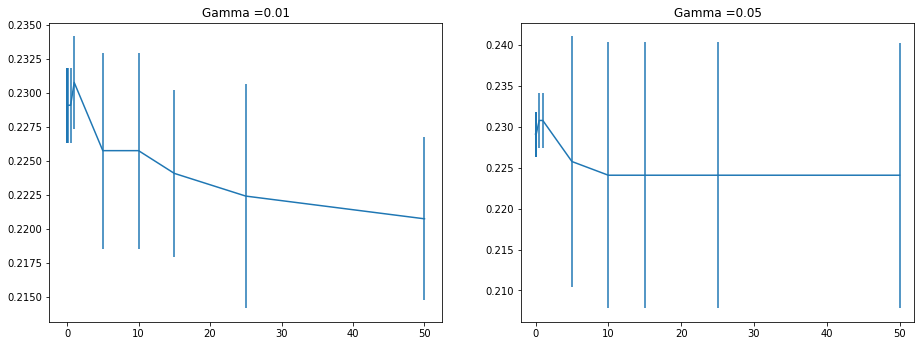

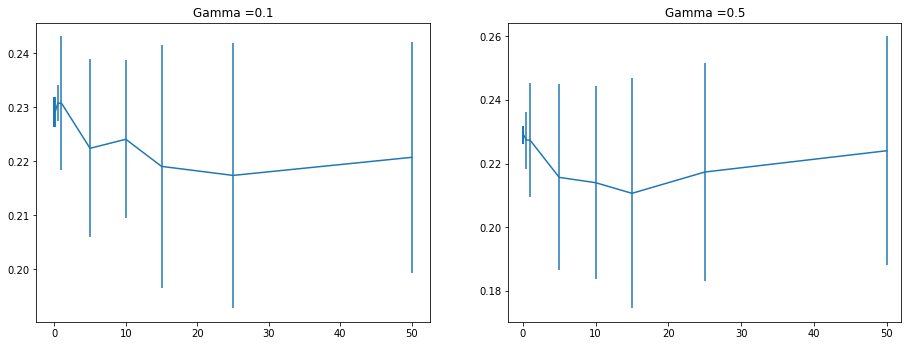

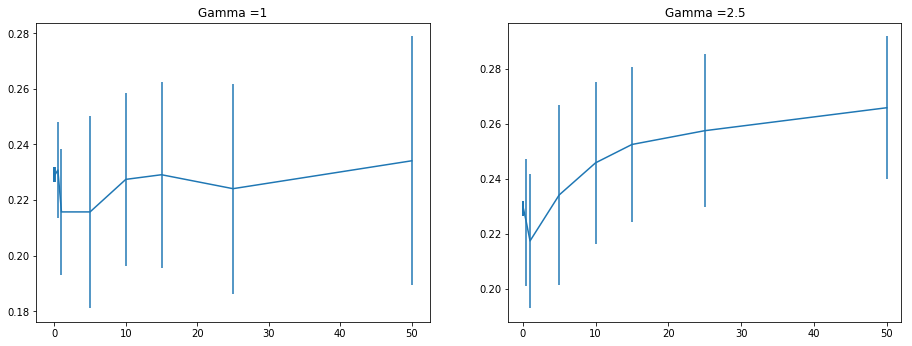

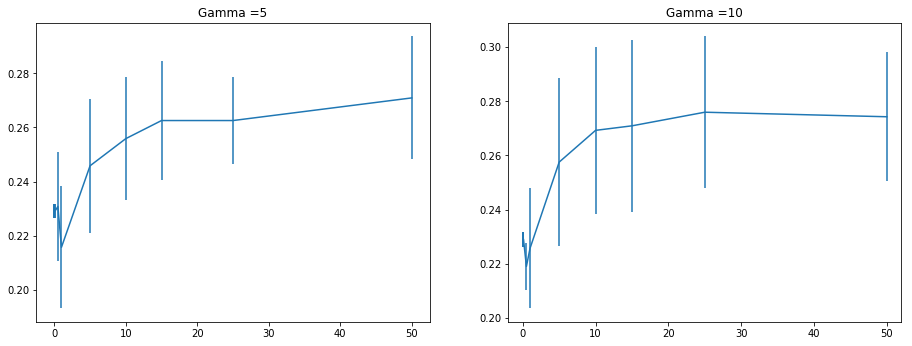

In [14]:
for gamma1, gamma2 in pairwise(gammas):
    fig, axs = plt.subplots(ncols=2, figsize=(15.5, 5.5))
    axs[0].set_title("Gamma =" +str(gamma1))
    axs[1].set_title("Gamma =" +str(gamma2))

    axs[0].errorbar(Cs, erroresRbf["Gamma:"+str(gamma1)], yerr=devsRbf["Gamma:"+str(gamma1)])
    plt.xlim(Cs[0]-2, Cs[len(Cs)-1]+2)

    axs[1].errorbar(Cs, erroresRbf["Gamma:"+str(gamma2)], yerr=devsRbf["Gamma:"+str(gamma2)])
    plt.xlim(Cs[0]-2, Cs[len(Cs)-1]+2)

Obtenemos las gráficas con el error de validación cruzada frente al valor de C para el kernel polinómico.

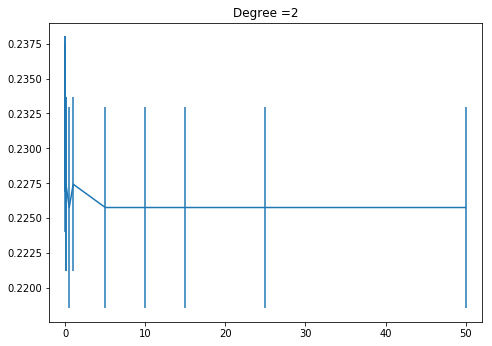

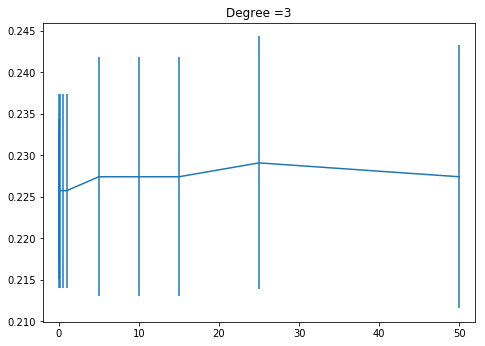

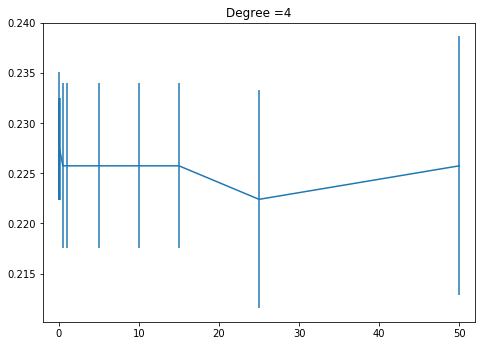

In [16]:
for degree in degrees:
    fig = plt.figure(figsize=(7.75,5.5))
    plt.title("Degree =" +str(degree))
    
    plt.errorbar(Cs, erroresPoly["Degree:"+str(degree)], yerr=devsPoly["Degree:"+str(degree)])
    plt.xlim(Cs[0]-2, Cs[len(Cs)-1]+2)



A continuación mostramos el menor error de entrenamiento, la desviación estándar y el valor del hiperparámetro con el que se corresponde para el kernel lineal.

In [20]:
##Menor error CV
best_param_cvLinear = modelCVLinear.best_params_['C']
print "Mejor parámetro:" , best_param_cvLinear
print "Error de entrenamiento: ", errListLinear[Cs.index(best_param_cvLinear)] 
print "Std: ", devListLinear[Cs.index(best_param_cvLinear)] 

 Mejor parámetro: 0.001
Error de entrenamiento:  0.229096989967
Std:  0.002752257941823252


De igual manera para el kernel `rbf`.

In [18]:
##Menor error CV
best_param_cv_rbf_C = modelCVRbf.best_params_["C"]
best_param_cv_rbf_gamma = modelCVRbf.best_params_["gamma"]
print "Mejores parámetros : C = " , best_param_cv_rbf_C, ", Gamma = ", best_param_cv_rbf_gamma
print "Error de entrenamiento: ", erroresRbf["Gamma:"+str(best_param_cv_rbf_gamma)][Cs.index(best_param_cv_rbf_C)]
print "Std: ", devsRbf["Gamma:"+str(best_param_cv_rbf_gamma)][Cs.index(best_param_cv_rbf_C)]

Mejores parámetros : C =  15 , Gamma =  0.5
Error de entrenamiento:  0.210702341137
Std:  0.03608875699984501


Y de igual manera para el kernel polinómico.

In [19]:
##Menor error CV
best_param_cv_poly_C = modelCVPoly.best_params_["C"]
best_param_cv_poly_degree = modelCVPoly.best_params_["degree"]
print "Mejores parámetros : C = " , best_param_cv_poly_C, ", Gamma = ", best_param_cv_poly_degree
print "Error de entrenamiento: ", erroresPoly["Degree:"+str(best_param_cv_poly_degree)][Cs.index(best_param_cv_poly_C)]
print "Std: ", devsPoly["Degree:"+str(best_param_cv_poly_degree)][Cs.index(best_param_cv_poly_C)]

Mejores parámetros : C =  25 , Gamma =  4
Error de entrenamiento:  0.222408026756
Std:  0.010860106988735635


Obtenemos a continuación la predicción en test para cada valor del hiperparámetro C usando el kernel lineal, y guardamos su error.

In [17]:
#Test error
testErrListLinear=[]
for C in Cs:
    model = svm.SVC(C = C, kernel='linear')
    model.fit(xTrain, yTrain)
    yPred=model.predict(xTest)
    testErrListLinear.append(1-metrics.accuracy_score(yTest,yPred))

De igual manera para cada valor de C y $\gamma$, usando el kernel `rbf`.

In [21]:
#Test error
testErrListRbf={ "Gamma:"+str(gamma):[] for C in Cs for gamma in gammas}
for C in Cs:
    for gamma in gammas:
        model = svm.SVC(C = C, kernel='rbf', gamma = gamma)
        model.fit(xTrain, yTrain)
        yPred=model.predict(xTest)
        testErrListRbf["Gamma:"+str(gamma)].append(1-metrics.accuracy_score(yTest,yPred))

De igual manera para cada valor de C y degree, usando el kernel polinómico.

In [ ]:
#Test error
testErrListPoly={ "Degree:"+str(degree):[] for C in Cs for degree in degrees}
for C in Cs:
    for degree in degrees:
        model = svm.SVC(C = C, kernel='poly', degree = degree, gamma = 1)
        model.fit(xTrain, yTrain)
        yPred=model.predict(xTest)
        testErrListPoly["Degree:"+str(degree)].append(1-metrics.accuracy_score(yTest,yPred))

A continuación mostramos el error de test, y el error de test comparado con el de entrenamiento para el kernel lineal.

<ErrorbarContainer object of 3 artists>

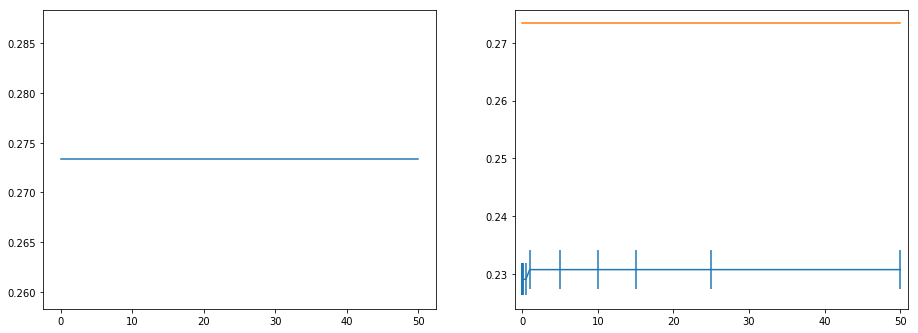

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(15.5, 5.5))

axs[0].errorbar(Cs, testErrListLinear)
plt.xlim(Cs[0]-1, Cs[len(Cs)-1]+1)

axs[1].errorbar(Cs, errListLinear, yerr=devListLinear)
plt.xlim(Cs[0]-1, Cs[len(Cs)-1]+1)
axs[1].errorbar(Cs, testErrListLinear) 


A continuación mostramos las gráficas del error de test comparadas con el de entrenamiento en el caso del kernel `rbf`, para cada valor de $\gamma$.

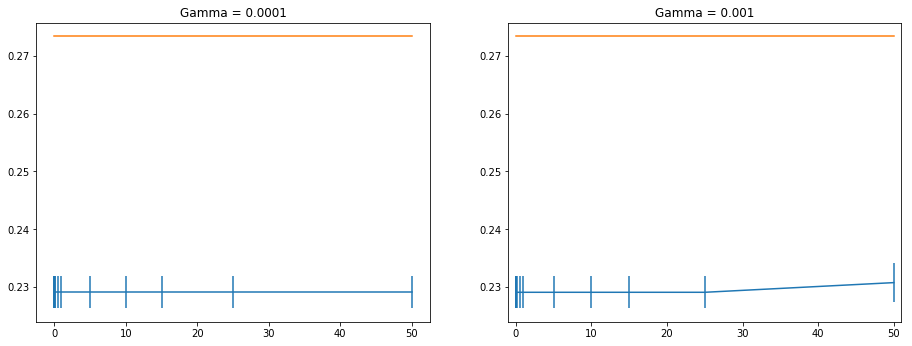

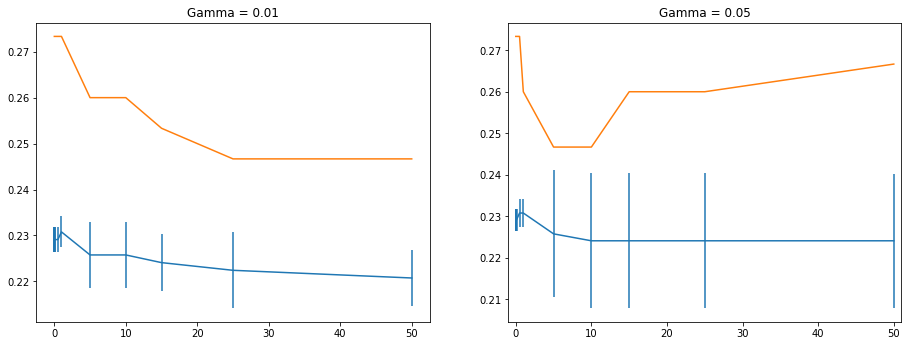

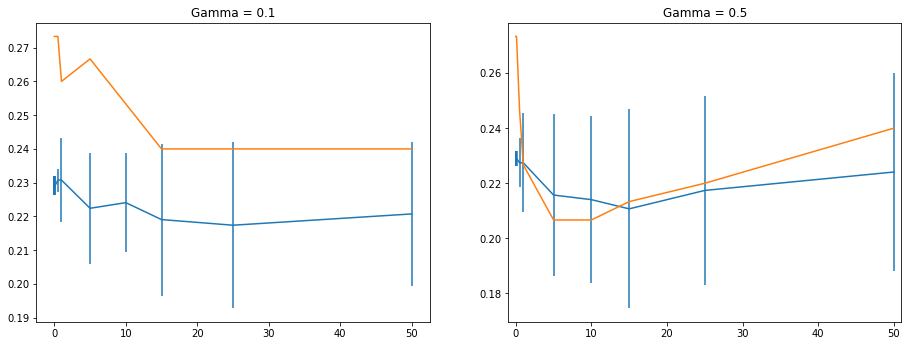

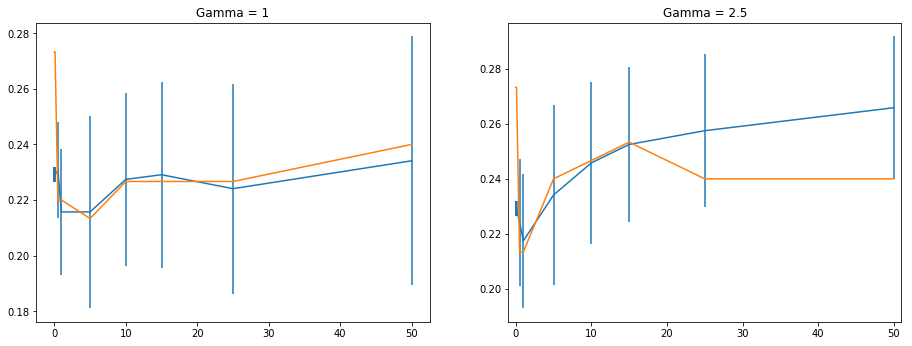

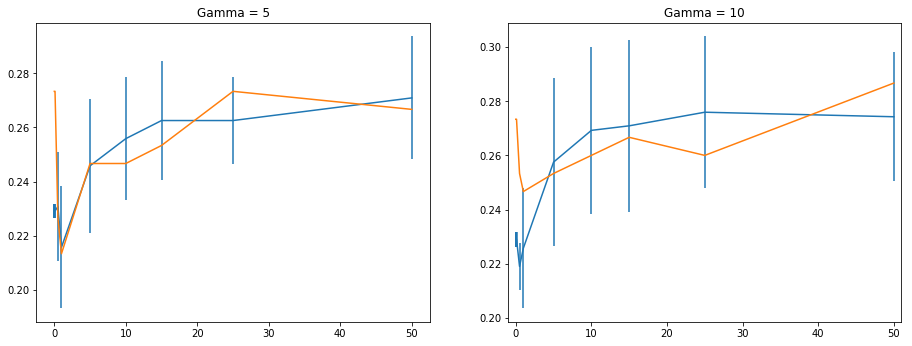

In [23]:
for gamma1, gamma2 in pairwise(gammas):
    fig, axs = plt.subplots(ncols=2, figsize=(15.5, 5.5))
    axs[0].set_title("Gamma = " +str(gamma1))
    axs[1].set_title("Gamma = " +str(gamma2))

    axs[0].errorbar(Cs, erroresRbf["Gamma:"+str(gamma1)], yerr=devsRbf["Gamma:"+str(gamma1)])
    plt.xlim(Cs[0]-1, Cs[len(Cs)-1]+1)
    axs[0].errorbar(Cs, testErrListRbf["Gamma:"+str(gamma1)])

    axs[1].errorbar(Cs, erroresRbf["Gamma:"+str(gamma2)], yerr=devsRbf["Gamma:"+str(gamma2)])
    plt.xlim(Cs[0]-1, Cs[len(Cs)-1]+1)
    axs[1].errorbar(Cs, testErrListRbf["Gamma:"+str(gamma2)])

De igual manera para el kernel polinómico, para cada valor de degree.

In [ ]:
for degree in degrees:
    fig = plt.figure(figsize=(7.75, 5.5))
    plt.title("Degree = " +str(degree))

    plt.errorbar(Cs, erroresPoly["Degree:"+str(degree)], yerr=devsPoly["Degree:"+str(degree)])
    plt.xlim(Cs[0]-1, Cs[len(Cs)-1]+1)
    plt.errorbar(Cs, testErrListPoly["Degree:"+str(degree)])

Menor error de test y errores de test para el mejor hiperparámetro de la cross validación del kernel lineal.

In [21]:
print "Menor error de test: ", min(testErrListLinear), " conseguido para el parámetro C =", Cs[np.argmin(testErrListLinear)]
print "Error de test para el parámetro C =", best_param_cvLinear ," elegido por la CV:", testErrListLinear[Cs.index(best_param_cvLinear)]


Menor error de test:  0.2733333333333333  conseguido para el parámetro C = 0.001
Error de test para el parámetro C = 0.001  elegido por la CV: 0.2733333333333333


De igual manera para el kernel `rbf`.

In [26]:
best_params_testRbf = min([(k, Cs[np.argmin(testErrListRbf[k])], min(testErrListRbf[k])) for k in testErrListRbf], key=itemgetter(2))
paramsRbf = best_params_testRbf[0].split(":")
best_param_test_gamma = paramsRbf[1]
print "Menor error de test: ", best_params_testRbf[2]
print "Conseguido para los parámetros Gamma = ", best_param_test_gamma, "y C = ", best_params_testRbf[1]
print "Error de test para los parámetros Gamma = " , best_param_cv_rbf_gamma, "y C = ", best_param_cv_rbf_C,","
print "elegidos por la CV:", testErrListRbf["Gamma:"+str(best_param_cv_rbf_gamma)][Cs.index(best_param_cv_rbf_C)]


Menor error de test:  0.20666666666666667
Conseguido para los parámetros Gamma =  0.5 y C =  5
Error de test para los parámetros Gamma =  0.5 y C =  15 ,
elegidos por la CV: 0.21333333333333337


De igual manera para el kernel polinómico.

In [ ]:
best_params_testPoly = min([(k, Cs[np.argmin(testErrListPoly[k])], min(testErrListPoly[k])) for k in testErrListPoly], key=itemgetter(2))
paramsPoly = best_params_testPoly[0].split(":")
best_param_test_degree = paramsPoly[1]
print "Menor error de test: ", best_params_testPoly[2]
print "Conseguido para los parámetros Degree = ", best_param_test_degree, "y C = ", best_params_testPoly[1]
print "Error de test para los parámetros Degree = " , best_param_cv_poly_degree, "y C = ", best_param_cv_poly_C,","
print "elegidos por la CV:", testErrListPoly["Degree:"+str(best_param_cv_poly_degree)][Cs.index(best_param_cv_poly_C)]


# Ejercicio 3

Fijamos la semilla, cargamos el nuevo dataset y dividimos en train/test como en el ejercicio anterior. Estandarizamos la entrada.

In [33]:
np.random.seed(1)
datasetName = '../datos/pima-indians-diabetes.data'
datasetDelimiter = ','

# load the CSV file as a numpy matrix
dataset_energy = np.loadtxt(datasetName, delimiter=datasetDelimiter)

xRaw2 = dataset_energy[:,0:dataset_energy.shape[1]-1]
y2 = dataset_energy[:,dataset_energy.shape[1]-1]

xTrain_tmp2, xTest_tmp2, yTrain2, yTest2 = cross_validation.train_test_split(xRaw2, y2, test_size=0.2)

#Standardize data
scaler = preprocessing.StandardScaler().fit(xTrain_tmp2)
xTrain2=scaler.transform(xTrain_tmp2)
xTest2=scaler.transform(xTest_tmp2)

Procedemos a realizar el entrenamiento para los valores de los hiperparámetros que se muestran a continuación, con el algoritmo `svm.SVC` de `scikit-learn`. De igual manera que antes, para el kernel lineal, solo se utiliza el hiperparámetro C. Para el kernel `rbf`, se utilizan C y $\gamma$. Y para el kernel polinómico, se utilizan C y degree.

In [24]:
#Generate grid search
kernels2 = ['linear', 'rbf', 'poly']
degrees2 = [2,3,4]
Cs2 = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,15,25,50]
gammas2 = [0.0001,0.001,0.01,0.05, 0.1, 0.5, 1, 2.5, 5, 10]

hyperParamsLinear2 = {'C': Cs2}
hyperParamsRbf2 = {'C': Cs2, 'gamma': gammas2}
hyperParamsPoly2 = {'C': Cs2, 'degree': degrees2}

modelCVLinear2 = GridSearchCV(svm.SVC(kernel="linear"), hyperParamsLinear2, cv=5, scoring='accuracy')
modelCVLinear2.fit(xTrain2, yTrain2)

print "Best hyperparameter", modelCVLinear2.best_params_
print "\n\n"

errListLinear2, devListLinear2 = [], []
for hyperP, mean_score, scores in modelCVLinear2.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std(), hyperP))
    errListLinear2.append(1-mean_score)
    devListLinear2.append(scores.std())

modelCVRbf2 = GridSearchCV(svm.SVC(kernel="rbf"), hyperParamsRbf2, cv=5, scoring='accuracy')
modelCVRbf2.fit(xTrain2, yTrain2)

print "\n\n"
print "Best hyperparameter", modelCVRbf2.best_params_
print "\n\n"

erroresRbf2 = { "Gamma:"+str(gamma):[] for gamma in gammas2}
devsRbf2 = { "Gamma:"+str(gamma):[] for gamma in gammas2}
for hyperP, mean_score, scores in modelCVRbf2.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std(), hyperP))
    erroresRbf2["Gamma:"+str(hyperP['gamma'])].append(1-mean_score)
    devsRbf2["Gamma:"+str(hyperP['gamma'])].append(scores.std())

modelCVPoly2 = GridSearchCV(svm.SVC(kernel="poly", gamma=1), hyperParamsPoly2, cv=5, scoring='accuracy')
modelCVPoly2.fit(xTrain2, yTrain2)

print "\n\n"
print "Best hyperparameter", modelCVPoly2.best_params_
print "\n\n"
    
erroresPoly2 = { "Degree:"+str(degree):[] for degree in degrees2}
devsPoly2 = { "Degree:"+str(degree):[] for degree in degrees2}
for hyperP, mean_score, scores in modelCVPoly2.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std(), hyperP))
    erroresPoly2["Degree:"+str(hyperP['degree'])].append(1-mean_score)
    devsPoly2["Degree:"+str(hyperP['degree'])].append(scores.std())

Best hyperparameter {'C': 0.01}



0.653 (+/-0.002) for {'C': 0.001}
0.756 (+/-0.014) for {'C': 0.005}
0.775 (+/-0.004) for {'C': 0.01}
0.770 (+/-0.011) for {'C': 0.05}
0.772 (+/-0.009) for {'C': 0.1}
0.769 (+/-0.009) for {'C': 0.5}
0.767 (+/-0.010) for {'C': 1}
0.769 (+/-0.009) for {'C': 5}
0.770 (+/-0.010) for {'C': 10}
0.770 (+/-0.010) for {'C': 15}
0.770 (+/-0.010) for {'C': 25}
0.770 (+/-0.010) for {'C': 50}



Best hyperparameter {'C': 10, 'gamma': 0.001}



0.653 (+/-0.002) for {'C': 0.001, 'gamma': 0.0001}
0.653 (+/-0.002) for {'C': 0.001, 'gamma': 0.001}
0.653 (+/-0.002) for {'C': 0.001, 'gamma': 0.01}
0.653 (+/-0.002) for {'C': 0.001, 'gamma': 0.05}
0.653 (+/-0.002) for {'C': 0.001, 'gamma': 0.1}
0.653 (+/-0.002) for {'C': 0.001, 'gamma': 0.5}
0.653 (+/-0.002) for {'C': 0.001, 'gamma': 1}
0.653 (+/-0.002) for {'C': 0.001, 'gamma': 2.5}
0.653 (+/-0.002) for {'C': 0.001, 'gamma': 5}
0.653 (+/-0.002) for {'C': 0.001, 'gamma': 10}
0.653 (+/-0.002) for {'C': 0.005, 'gamma': 0.0001

A continuación mostramos las gráficas del error de entrenamiento de igual manera que en el ejercicio anterior.

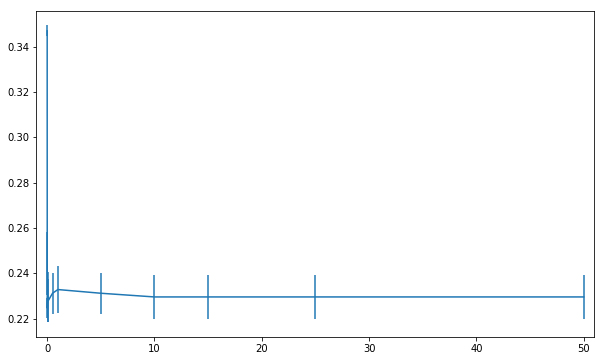

In [25]:
plt.figure(figsize=(10,6))
plt.errorbar(Cs2, errListLinear2, yerr=devListLinear2)
plt.xlim(Cs2[0]-1, Cs2[len(Cs2)-1]+1)
plt.show()

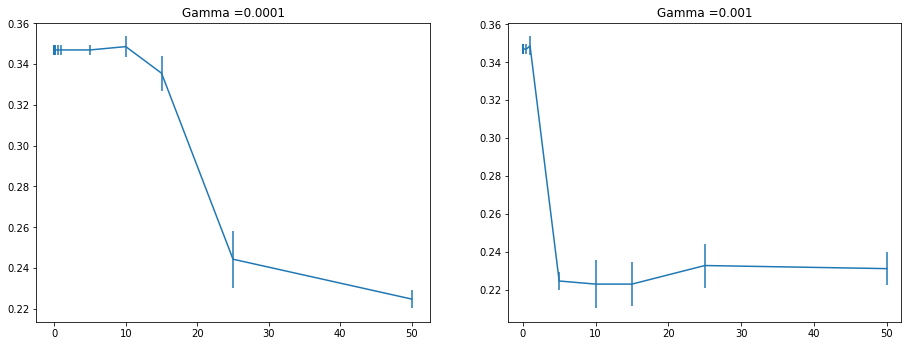

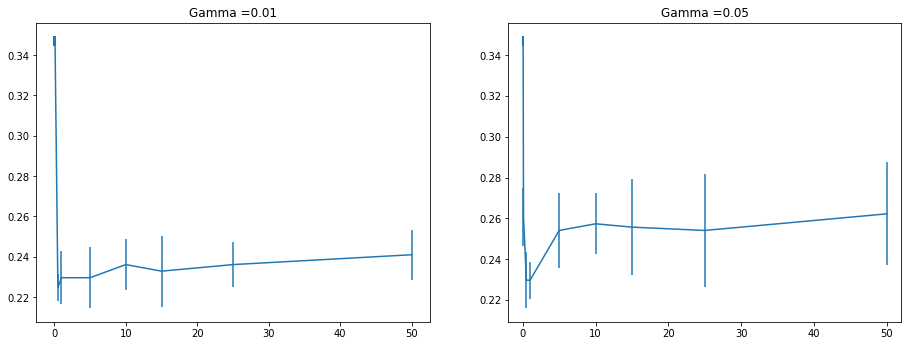

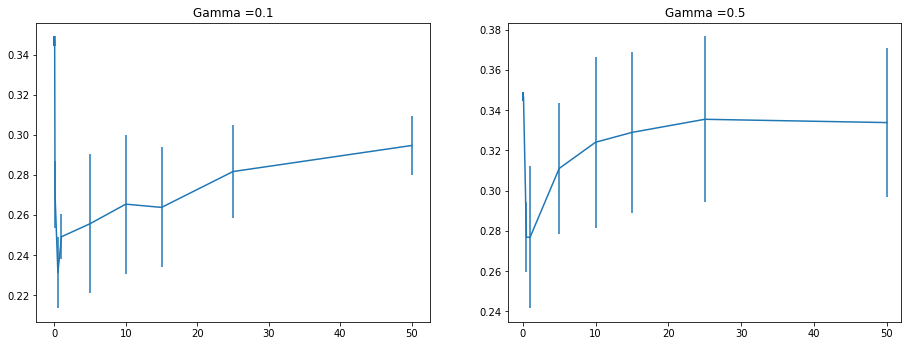

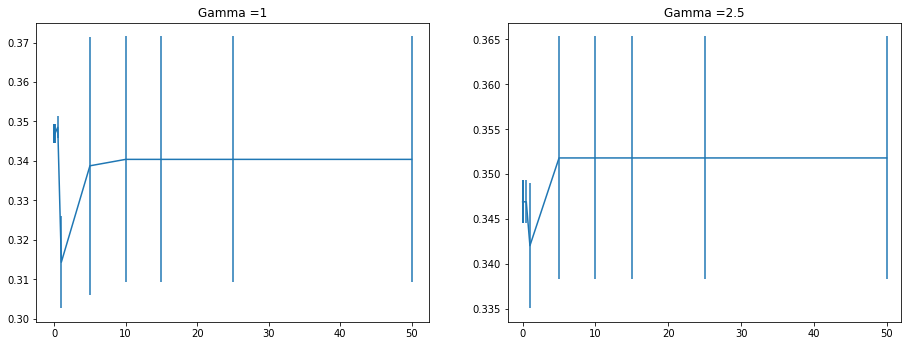

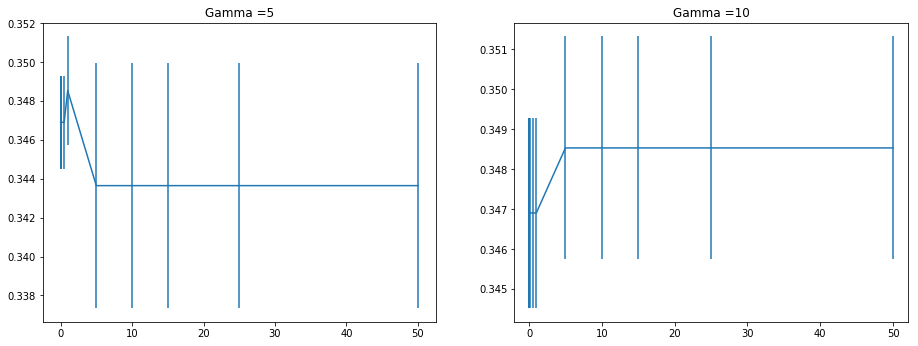

In [26]:
for gamma1, gamma2 in pairwise(gammas2):
    fig, axs = plt.subplots(ncols=2, figsize=(15.5, 5.5))
    axs[0].set_title("Gamma =" +str(gamma1))
    axs[1].set_title("Gamma =" +str(gamma2))

    axs[0].errorbar(Cs2, erroresRbf2["Gamma:"+str(gamma1)], yerr=devsRbf2["Gamma:"+str(gamma1)])
    plt.xlim(Cs2[0]-2, Cs2[len(Cs2)-1]+2)

    axs[1].errorbar(Cs2, erroresRbf2["Gamma:"+str(gamma2)], yerr=devsRbf2["Gamma:"+str(gamma2)])
    plt.xlim(Cs2[0]-2, Cs2[len(Cs2)-1]+2)

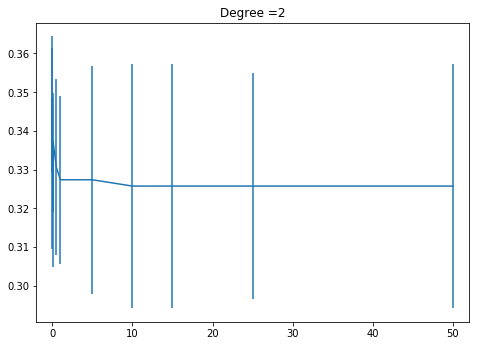

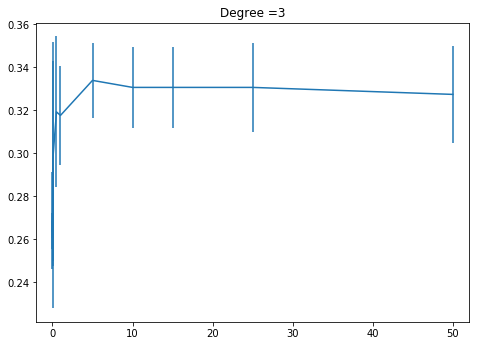

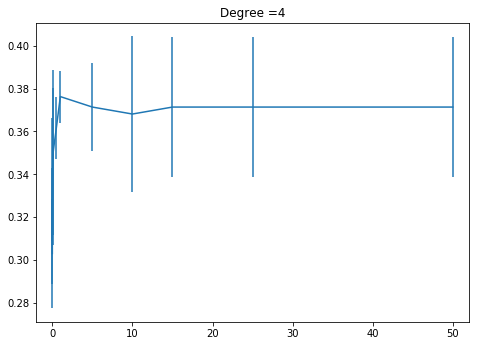

In [27]:
for degree in degrees2:
    fig = plt.figure(figsize=(7.75,5.5))
    plt.title("Degree =" +str(degree))
    
    plt.errorbar(Cs2, erroresPoly2["Degree:"+str(degree)], yerr=devsPoly2["Degree:"+str(degree)])
    plt.xlim(Cs2[0]-2, Cs2[len(Cs2)-1]+2)


Menor error de entrenamiento, su hiperparámetro y su desviación típica para el kernel lineal.

In [28]:
##Menor error CV
best_param_cvLinear2 = modelCVLinear2.best_params_['C']
print "Mejor parámetro:" , best_param_cvLinear2
print "Error de entrenamiento: ", errListLinear2[Cs2.index(best_param_cvLinear2)] 
print "Std: ", devListLinear2[Cs2.index(best_param_cvLinear2)] 

Mejor parámetro: 0.01
Error de entrenamiento:  0.224755700326
Std:  0.004478962650047648


De igual manera para el kernel `rbf`.

In [29]:
##Menor error CV
best_param_cv_rbf_C2 = modelCVRbf2.best_params_["C"]
best_param_cv_rbf_gamma2 = modelCVRbf2.best_params_["gamma"]
print "Mejores parámetros : C = " , best_param_cv_rbf_C2, ", Gamma = ", best_param_cv_rbf_gamma2
print "Error de entrenamiento: ", erroresRbf2["Gamma:"+str(best_param_cv_rbf_gamma2)][Cs2.index(best_param_cv_rbf_C2)]
print "Std: ", devsRbf2["Gamma:"+str(best_param_cv_rbf_gamma2)][Cs2.index(best_param_cv_rbf_C2)]

Mejores parámetros : C =  10 , Gamma =  0.001
Error de entrenamiento:  0.223127035831
Std:  0.012698455759947472


De igual manera para el kernel polinómico.

In [30]:
##Menor error CV
best_param_cv_poly_C2 = modelCVPoly2.best_params_["C"]
best_param_cv_poly_degree2 = modelCVPoly2.best_params_["degree"]
print "Mejores parámetros : C = " , best_param_cv_poly_C2, ", Degree = ", best_param_cv_poly_degree2
print "Error de entrenamiento: ", erroresPoly2["Degree:"+str(best_param_cv_poly_degree2)][Cs2.index(best_param_cv_poly_C2)]
print "Std: ", devsPoly2["Degree:"+str(best_param_cv_poly_degree2)][Cs2.index(best_param_cv_poly_C2)]

Mejores parámetros : C =  0.01 , Degree =  3
Error de entrenamiento:  0.260586319218
Std:  0.03266128582894156


Obtenemos los errores de test de igual manera que en el ejercicio anterior.

In [34]:
#Test error
testErrListLinear2=[]
for C in Cs2:
    model = svm.SVC(C = C, kernel='linear')
    model.fit(xTrain2, yTrain2)
    yPred2=model.predict(xTest2)
    testErrListLinear2.append(1-metrics.accuracy_score(yTest2,yPred2))

In [35]:
#Test error
testErrListRbf2={ "Gamma:"+str(gamma):[] for C in Cs2 for gamma in gammas2}
for C in Cs2:
    for gamma in gammas2:
        model = svm.SVC(C = C, kernel='rbf', gamma = gamma)
        model.fit(xTrain2, yTrain2)
        yPred2=model.predict(xTest2)
        testErrListRbf2["Gamma:"+str(gamma)].append(1-metrics.accuracy_score(yTest2,yPred2))

In [ ]:
#Test error
testErrListPoly2={ "Degree:"+str(degree):[] for C in Cs2 for degree in degrees2}
for C in Cs2:
    for degree in degrees2:
        model = svm.SVC(C = C, kernel='poly', degree = degree, gamma = 1)
        model.fit(xTrain2, yTrain2)
        yPred2=model.predict(xTest2)
        testErrListPoly2["Degree:"+str(degree)].append(1-metrics.accuracy_score(yTest2,yPred2))

Gráficas con el error de test y el error de entrenamiento comparado con el de test, con respecto al valor del hiperparámetro, para el kernel lineal.

<ErrorbarContainer object of 3 artists>

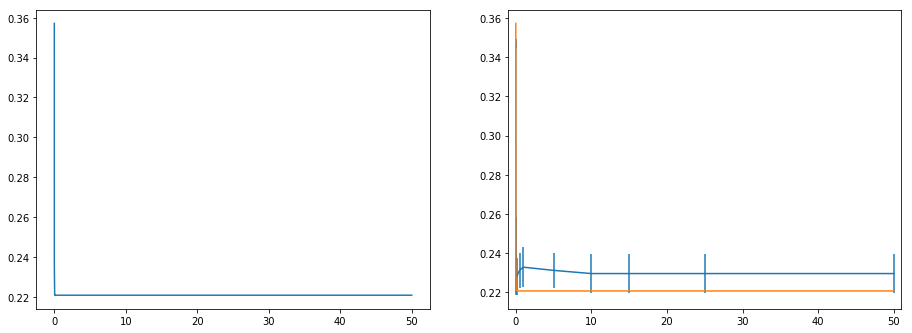

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(15.5, 5.5))

axs[0].errorbar(Cs2, testErrListLinear2)
plt.xlim(Cs2[0]-1, Cs2[len(Cs2)-1]+1)

axs[1].errorbar(Cs2, errListLinear2, yerr=devListLinear2)
plt.xlim(Cs2[0]-1, Cs2[len(Cs2)-1]+1)
axs[1].errorbar(Cs2, testErrListLinear2) 


Gráficas con el error de test comparado con el de entrenamiento para el kernel `rbf`.

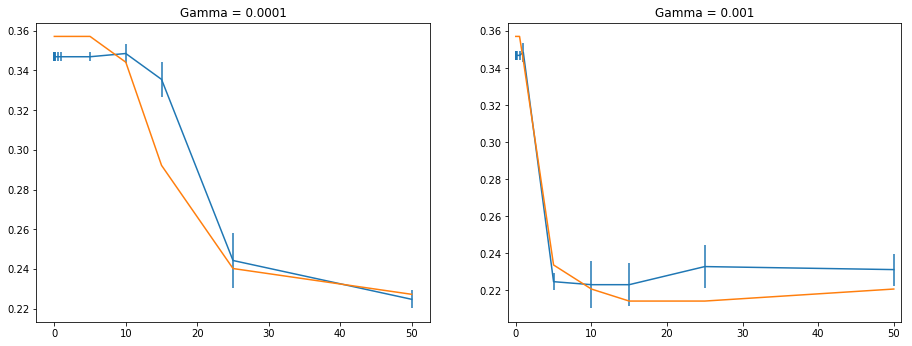

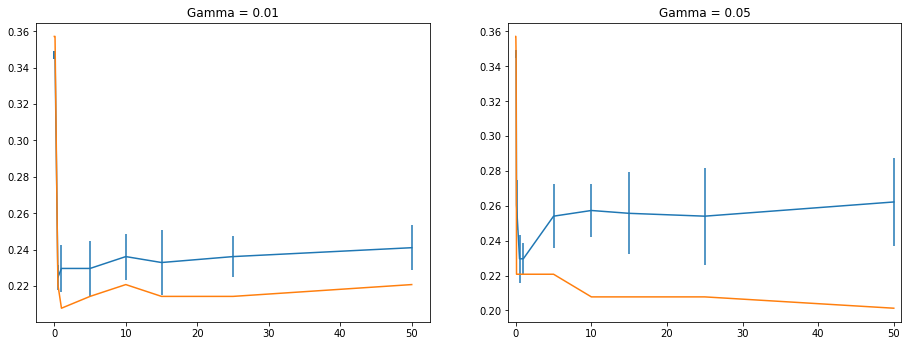

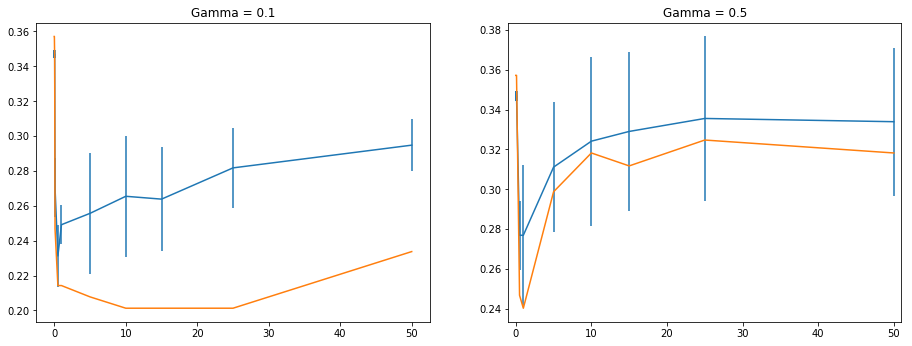

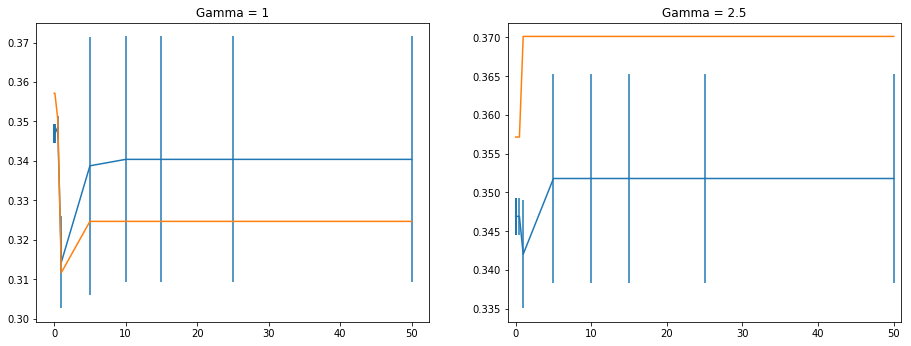

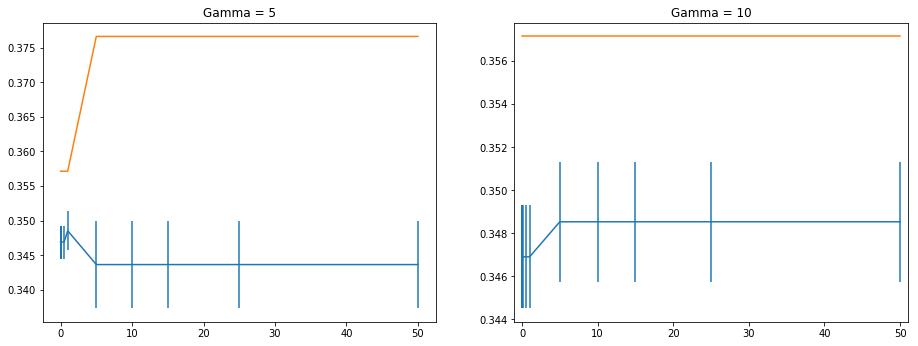

In [38]:
for gamma1, gamma2 in pairwise(gammas2):
    fig, axs = plt.subplots(ncols=2, figsize=(15.5, 5.5))
    axs[0].set_title("Gamma = " +str(gamma1))
    axs[1].set_title("Gamma = " +str(gamma2))

    axs[0].errorbar(Cs2, erroresRbf2["Gamma:"+str(gamma1)], yerr=devsRbf2["Gamma:"+str(gamma1)])
    plt.xlim(Cs2[0]-1, Cs2[len(Cs2)-1]+1)
    axs[0].errorbar(Cs2, testErrListRbf2["Gamma:"+str(gamma1)])

    axs[1].errorbar(Cs2, erroresRbf2["Gamma:"+str(gamma2)], yerr=devsRbf2["Gamma:"+str(gamma2)])
    plt.xlim(Cs2[0]-1, Cs2[len(Cs2)-1]+1)
    axs[1].errorbar(Cs2, testErrListRbf2["Gamma:"+str(gamma2)])

De igual manera para el kernel polinómico.

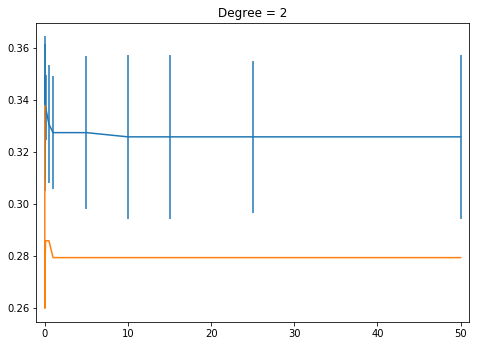

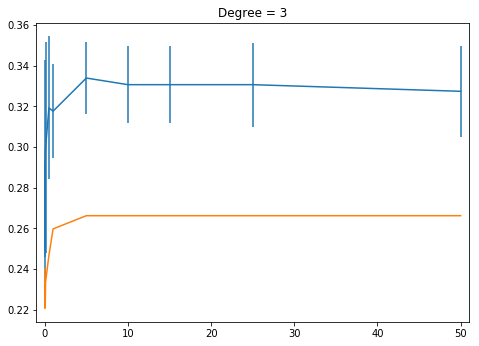

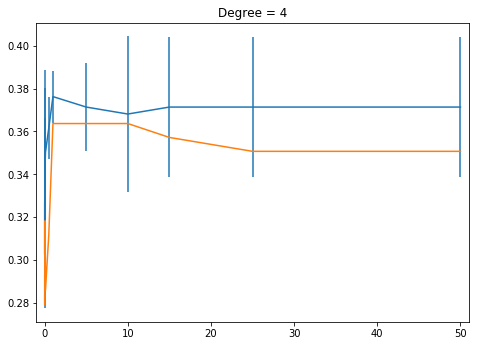

In [41]:
for degree in degrees2:
    fig = plt.figure(figsize=(7.75, 5.5))
    plt.title("Degree = " +str(degree))

    plt.errorbar(Cs2, erroresPoly2["Degree:"+str(degree)], yerr=devsPoly2["Degree:"+str(degree)])
    plt.xlim(Cs2[0]-1, Cs2[len(Cs2)-1]+1)
    plt.errorbar(Cs2, testErrListPoly2["Degree:"+str(degree)])

Mostramos el menor error de test, y el error de test para el mejor hiperparámetro de la cross validación, usando el kernel lineal.

In [42]:
print "Menor error de test: ", min(testErrListLinear2), " conseguido para el parámetro C =", Cs2[np.argmin(testErrListLinear2)]
print "Error de test para el parámetro C =", best_param_cvLinear2 ," elegido por la CV:", testErrListLinear2[Cs2.index(best_param_cvLinear2)]

Menor error de test:  0.22077922077922074  conseguido para el parámetro C = 0.05
Error de test para el parámetro C = 0.01  elegido por la CV: 0.23376623376623373


De igual manera para el kernel `rbf`.

In [43]:
best_params_testRbf2 = min([(k, Cs2[np.argmin(testErrListRbf2[k])], min(testErrListRbf2[k])) for k in testErrListRbf2], key=itemgetter(2))
paramsRbf2 = best_params_testRbf2[0].split(":")
best_param_test_gamma2 = paramsRbf2[1]
print "Menor error de test: ", best_params_testRbf2[2]
print "Conseguido para los parámetros Gamma = ", best_param_test_gamma2, "y C = ", best_params_testRbf2[1]
print "Error de test para los parámetros Gamma = " , best_param_cv_rbf_gamma2, "y C = ", best_param_cv_rbf_C2,","
print "elegidos por la CV:", testErrListRbf2["Gamma:"+str(best_param_cv_rbf_gamma2)][Cs2.index(best_param_cv_rbf_C2)]


Menor error de test:  0.2012987012987013
Conseguido para los parámetros Gamma =  0.05 y C =  50
Error de test para los parámetros Gamma =  0.001 y C =  10 ,
elegidos por la CV: 0.22077922077922074


De igual manera para el kernel polinómico.

In [44]:
best_params_testPoly2 = min([(k, Cs2[np.argmin(testErrListPoly2[k])], min(testErrListPoly2[k])) for k in testErrListPoly2], key=itemgetter(2))
paramsPoly2 = best_params_testPoly2[0].split(":")
best_param_test_degree2 = paramsPoly2[1]
print "Menor error de test: ", best_params_testPoly2[2]
print "Conseguido para los parámetros Degree = ", best_param_test_degree2, "y C = ", best_params_testPoly2[1]
print "Error de test para los parámetros Degree = " , best_param_cv_poly_degree2, "y C = ", best_param_cv_poly_C2,","
print "elegidos por la CV:", testErrListPoly2["Degree:"+str(best_param_cv_poly_degree2)][Cs2.index(best_param_cv_poly_C2)]


Menor error de test:  0.22077922077922074
Conseguido para los parámetros Degree =  3 y C =  0.005
Error de test para los parámetros Degree =  3 y C =  0.01 ,
elegidos por la CV: 0.22077922077922074
